In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [3]:
df=pd.read_csv('/content/drive/MyDrive/Datasets/inventory_data.csv')

In [4]:
df.head()

,timestamp,product_id,estimated_stock_pct,quantity,temperature
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.02885
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.02885
2,2022-03-01 09:00:00,0ddc2379-adba-4fb0-aa97-19fcafc738a1,0.35,3.0,-0.02885
3,2022-03-01 09:00:00,146d5e4d-992a-4db7-904d-b8af359b80a7,0.48,1.0,-0.02885
4,2022-03-01 09:00:00,14736243-d346-438f-9535-d80fcb9f3882,0.67,6.0,-0.02885


In [5]:
df.tail()

,timestamp,product_id,estimated_stock_pct,quantity,temperature
10840,2022-03-07 19:00:00,e68b76ae-951d-4d82-8168-e78d46711883,0.20,NaN,-0.165077
10841,2022-03-07 19:00:00,ec0bb9b5-45e3-4de8-963d-e92aa91a201e,0.34,NaN,-0.165077
10842,2022-03-07 19:00:00,ec4aa84b-bcb9-4b6a-b5ef-1ab2462e15a0,0.93,NaN,-0.165077
10843,2022-03-07 19:00:00,edf4ac93-4e14-4a3d-8c60-e715210cf3f9,0.78,3.0,-0.165077
10844,2022-03-07 19:00:00,f01b189c-6345-4639-a8d1-89e1fc67c443,0.92,3.0,-0.165077


## We've just 1 week of hourly data

In [6]:
df['timestamp'].min(), df['timestamp'].max()

('2022-03-01 09:00:00', '2022-03-07 19:00:00')

In [7]:
df.sample(5)

,timestamp,product_id,estimated_stock_pct,quantity,temperature
5585,2022-03-07 14:00:00,26583d39-21dd-4404-9f95-ceda18a26be4,0.600,NaN,-0.105570
10288,2022-03-07 12:00:00,29110d35-9473-4ae4-b971-0fb62825aa9a,0.355,11.0,-0.236012
6447,2022-03-01 17:00:00,89968f6a-b575-46ff-b71e-2238826be41b,0.710,NaN,-0.376415
39,2022-03-01 09:00:00,cbab5824-54de-447f-8282-6683f5a27a47,0.010,1.0,-0.028850
9420,2022-03-06 10:00:00,9ed419c7-391a-4b1a-87d9-b311ebe93c75,0.495,NaN,-0.365407


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10845 entries, 0 to 10844
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            10845 non-null  object 
 1   product_id           10845 non-null  object 
 2   estimated_stock_pct  10845 non-null  float64
 3   quantity             3067 non-null   float64
 4   temperature          10845 non-null  float64
dtypes: float64(3), object(2)
memory usage: 423.8+ KB


In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [10]:
df.isnull().sum()

,0
timestamp,0
product_id,0
estimated_stock_pct,0
quantity,7778
temperature,0


In [11]:
df.describe()

,timestamp,estimated_stock_pct,quantity,temperature
count,10845,10845.000000,3067.000000,10845.000000
mean,2022-03-04 14:15:38.091286272,0.505130,3.212586,-0.213678
min,2022-03-01 09:00:00,0.010000,1.000000,-1.847270
25%,2022-03-02 17:00:00,0.300000,2.000000,-0.657082
50%,2022-03-04 14:00:00,0.500000,3.000000,-0.230631
75%,2022-03-06 11:00:00,0.715000,4.000000,0.160429
max,2022-03-07 19:00:00,1.000000,15.000000,1.435940
std,NaN,0.264519,1.974511,0.649671


In [12]:
# Extract datetime features from timestamp
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)  # Weekend indicator

In [13]:
# Fill missing values with mean or median
df['quantity'].fillna(df['quantity'].median(), inplace=True)
df['temperature'].fillna(df['temperature'].mean(), inplace=True)

In [14]:
df0 = df.drop(['product_id','timestamp'], axis=1)

In [15]:
df0.corr()['estimated_stock_pct']

,estimated_stock_pct
estimated_stock_pct,1.000000
quantity,-0.004453
temperature,0.007955
year,NaN
month,NaN
day,0.001786
hour,0.012894
day_of_week,-0.013880
is_weekend,-0.005273


In [16]:
df1 = df.drop(['product_id'], axis=1)

In [17]:
# Function to create lagged features
def create_lagged_features(df, target_column, lags):
    for lag in lags:
        df[f'{target_column}_lag_{lag}'] = df[target_column].shift(lag)
    df.dropna(inplace=True)
    return df

In [18]:
# Define the lags (e.g., previous 1, 2, 3, 6, 12, 24 hours)
lags = [1, 2, 3, 6, 12, 24]

# Create lagged features
df_lagged = create_lagged_features(df1.copy(), 'estimated_stock_pct', lags)

In [19]:
# Perform train-test split (last 2 days for testing, rest for training)
train_df = df_lagged[df_lagged['timestamp'] < '2022-03-06']
test_df = df_lagged[df_lagged['timestamp'] >= '2022-03-06']

In [20]:
# Define features and target
X_train = train_df.drop(['timestamp', 'estimated_stock_pct'], axis=1)
y_train = train_df['estimated_stock_pct']

In [21]:
X_test = test_df.drop(['timestamp', 'estimated_stock_pct'], axis=1)
y_test = test_df['estimated_stock_pct']

## XGBoost Regressor

In [22]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10845 entries, 0 to 10844
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            10845 non-null  datetime64[ns]
 1   estimated_stock_pct  10845 non-null  float64       
 2   quantity             10845 non-null  float64       
 3   temperature          10845 non-null  float64       
 4   year                 10845 non-null  int32         
 5   month                10845 non-null  int32         
 6   day                  10845 non-null  int32         
 7   hour                 10845 non-null  int32         
 8   day_of_week          10845 non-null  int32         
 9   is_weekend           10845 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int32(5), int64(1)
memory usage: 635.6 KB


In [23]:
from xgboost import XGBRegressor

# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.01)

In [24]:
# Train the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [25]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

In [26]:
from sklearn.metrics import mean_squared_error
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse:.4f}')

Root Mean Squared Error: 0.2644


In [27]:
# Create future time periods for the next week
last_timestamp = df['timestamp'].max()
future_dates = pd.date_range(last_timestamp, periods=7 * 24 + 1, freq='H')[1:]  # next 1 week

In [28]:
# Create a DataFrame for the future predictions
future_df = pd.DataFrame({'timestamp': future_dates})

In [29]:
# Add datetime features to future_df
future_df['year'] = future_df['timestamp'].dt.year
future_df['month'] = future_df['timestamp'].dt.month
future_df['day'] = future_df['timestamp'].dt.day
future_df['hour'] = future_df['timestamp'].dt.hour
future_df['day_of_week'] = future_df['timestamp'].dt.dayofweek
future_df['is_weekend'] = (future_df['day_of_week'] >= 5).astype(int)

In [30]:
# Fill in the future_df with the last known values for quantity and temperature
future_df['quantity'] = df_lagged['quantity'].iloc[-1]
future_df['temperature'] = df_lagged['temperature'].iloc[-1]

In [31]:
# Fill in lagged features for future dates by propagating the last known value
for lag in lags:
    future_df[f'estimated_stock_pct_lag_{lag}'] = df_lagged[f'estimated_stock_pct_lag_{lag}'].iloc[-1]

In [32]:
# Predict the estimated_stock_pct for the future dates
X_future = future_df.drop(['timestamp'], axis=1)

In [33]:
# Ensure the feature order matches the training data
X_future = X_future[X_train.columns]

In [34]:
# Predict the estimated_stock_pct for the future dates
y_future_pred = xgb_model.predict(X_future)

In [35]:
# Add predictions to the future_df
future_df['estimated_stock_pct'] = y_future_pred

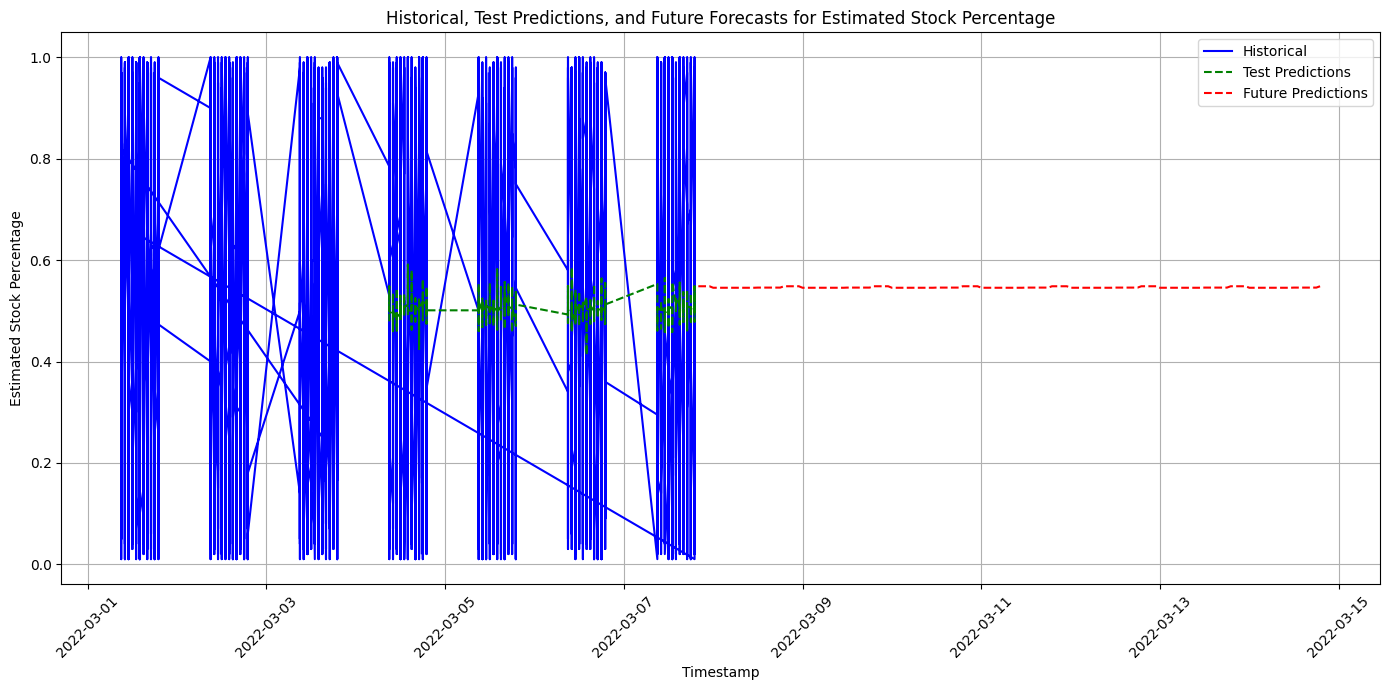

In [36]:
import matplotlib.pyplot as plt

# Generate predictions for the test data
X_test = X_test.copy()  # Ensure X_test is in the right format
y_test_pred = xgb_model.predict(X_test)

# Create DataFrames for test predictions
test_df = pd.DataFrame({
    'timestamp': df.iloc[len(df) - len(y_test):]['timestamp'].values,
    'estimated_stock_pct': y_test_pred
})

# Combine historical data, test predictions, and future predictions
plot_df = pd.DataFrame({
    'timestamp': pd.concat([df['timestamp'], test_df['timestamp'], future_df['timestamp']]),
    'estimated_stock_pct': pd.concat([df['estimated_stock_pct'], test_df['estimated_stock_pct'], pd.Series(y_future_pred, index=future_df.index)])
})

# Separate historical, test, and future data for plotting
historical_df = plot_df.iloc[:len(df)]
test_df = plot_df.iloc[len(df):len(df) + len(test_df)]
predicted_df = plot_df.iloc[len(df) + len(test_df):]

# Plotting
plt.figure(figsize=(14, 7))

# Plot historical values
plt.plot(historical_df['timestamp'], historical_df['estimated_stock_pct'], label='Historical', color='blue')

# Plot test predictions
plt.plot(test_df['timestamp'], test_df['estimated_stock_pct'], label='Test Predictions', color='green', linestyle='--')

# Plot future predictions
plt.plot(predicted_df['timestamp'], predicted_df['estimated_stock_pct'], label='Future Predictions', color='red', linestyle='--')

# Add title and labels
plt.title('Historical, Test Predictions, and Future Forecasts for Estimated Stock Percentage')
plt.xlabel('Timestamp')
plt.ylabel('Estimated Stock Percentage')

# Show legend
plt.legend()

# Show plot
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()